In [ ]:
#pip install pandahouse

In [ ]:
import pandahouse

In [ ]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [ ]:
q = """
SELECT exp_group, user_id, sum(action = 'like') as likes, sum(action = 'view') as views,
likes/views as ctr
FROM simulator_20230920.feed_actions
WHERE toDate(time) between '2023-08-29' and '2023-09-04' and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)
df.head(3)

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122


In [ ]:
from scipy import stats
import seaborn as sns
import numpy as np

In [ ]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var = False
                )

TtestResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44, df=19911.289778579154)

In [ ]:
group0 = df[df.exp_group == 0]
group3 = df[df.exp_group == 3]
group0.head(3)

,exp_group,user_id,likes,views,ctr
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000


In [ ]:
ctr_0 = group0.likes.sum()/group0.views.sum()
group0['linear_likes'] = group0.likes-ctr_0*group0.views
group3['linear_likes'] = group3.likes-ctr_0*group3.views

<ipython-input-23-300adc16157f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group0['linear_likes'] = group0.likes-ctr_0*group0.views
<ipython-input-23-300adc16157f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group3['linear_likes'] = group3.likes-ctr_0*group3.views


In [ ]:
stats.ttest_ind(group0['linear_likes'],
                group3['linear_likes'],
                equal_var = False
                )

TtestResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58, df=19912.675643203424)

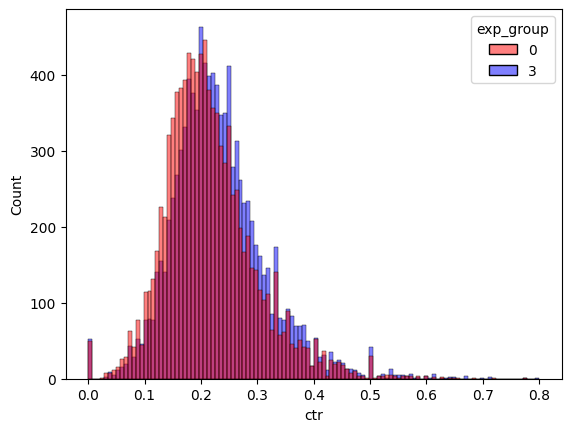

In [ ]:
groups = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

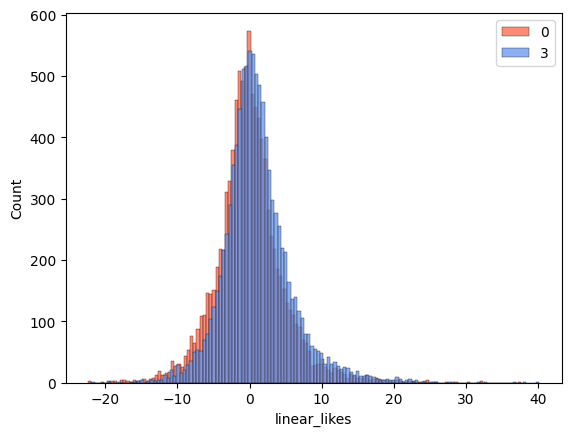

In [ ]:
import matplotlib.pyplot as plt
sns.histplot(group0['linear_likes'], color = 'tomato', legend = True)
sns.histplot(group3['linear_likes'], color = 'cornflowerblue', legend = True)
plt.legend(['0', '3'])
plt.show()

- Видим, что значение p_value стало ещё меньше, то есть метрика стала ещё чувствительнее.  
  
Посмотрим теперь для что произойдёт при линеаризации лайков в __группах 1 и 2__. Помним что для обычных ctr __t-test не красился__
.

In [ ]:
q = """
SELECT exp_group, user_id, sum(action = 'like') as likes, sum(action = 'view') as views,
likes/views as ctr
FROM simulator_20230920.feed_actions
WHERE toDate(time) between '2023-08-29' and '2023-09-04' and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection = connection)
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


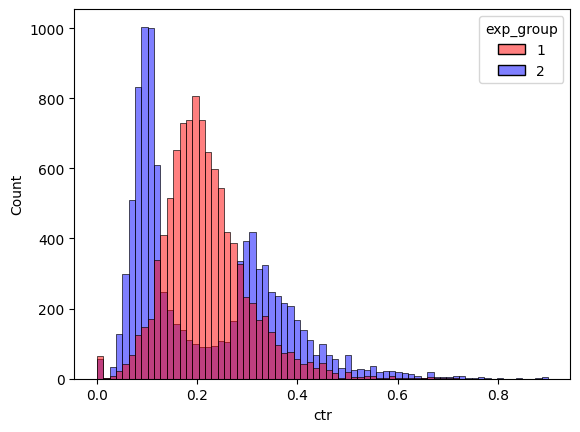

In [ ]:
groups = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

In [ ]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var = False
                )

TtestResult(statistic=0.4051491913112757, pvalue=0.685373331140751, df=15811.22649797086)

In [ ]:
group1 = df[df.exp_group == 1]
group2 = df[df.exp_group == 2]
group0.head(3)

,exp_group,user_id,likes,views,ctr,linear_likes
2,0,4944,8,41,0.195122,-0.603358
3,0,4504,5,15,0.333333,1.852430
4,0,121508,6,25,0.240000,0.754050


In [ ]:
ctr_1 = group1.likes.sum()/group1.views.sum()
group1['linear_likes'] = group1.likes-ctr_1*group1.views
group2['linear_likes'] = group2.likes-ctr_1*group2.views

<ipython-input-31-b8c09d2f7fb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group1['linear_likes'] = group1.likes-ctr_1*group1.views
<ipython-input-31-b8c09d2f7fb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group2['linear_likes'] = group2.likes-ctr_1*group2.views


In [ ]:
stats.ttest_ind(group1['linear_likes'],
                group2['linear_likes'],
                equal_var = False
                )

TtestResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09, df=14482.887340383999)

Видим, что на линеаризованных лайках __t-test очень прокрасился__.
Помним, что если тест на этой метрике «прокрасится» и увидит изменения, значит __изменения есть и в метрике исходной__ (то есть в лайках на пользователя и в пользовательских CTR).

In [ ]:
ctr = df.likes.sum()/df.views.sum()
df['linear_likes'] = df.likes-ctr*df.views

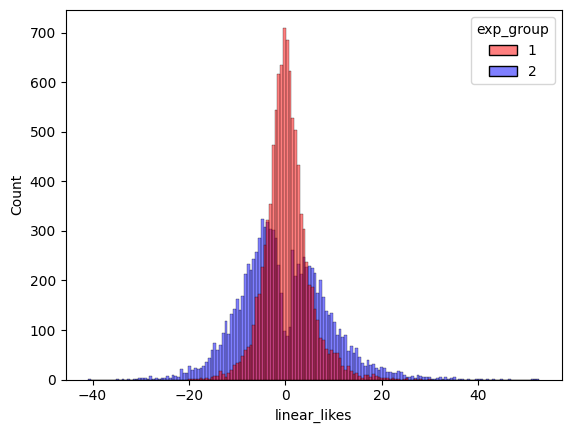

In [ ]:
groups = sns.histplot(data = df,  x = 'linear_likes', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)